# Role Classifier AI
This notebook contains AI model that is able to classify images into their roles (informative, decorative, functional, text, or complex). The model takes image and several text attributes as input and outputs a role.

## Load Data

In [78]:
# Install dependencies
%pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [79]:
import os
import json
import pandas as pd

# Define the path to the directory containing the JSON files
json_dir = "../scraper/output"

# Initialize empty lists to store the image links and textual contexts
srcs = []
file_names = []
roles = []
alts = []
attrs = []
a_button_parents = []
previous_texts = []
next_texts = []
textual_contexts = []

images = []

# Loop through each JSON file in the directory
for filename in os.listdir(json_dir):
    if filename.endswith(".json"):
        # Read the JSON file
        with open(os.path.join(json_dir, filename), "r") as file:
            data = json.load(file)
        
        # Extract the image link and textual context from the JSON data
        whole_text = data["text"]
        sub_images = data["images"]

        images.extend(sub_images)

        for image in images:
            # {
            #     "src": "http://donutworrybehappy.eu/getattachment/71afc349-9d82-4861-9324-1d304061f188/hero-section.aspx",
            #     "file_name": "./images/donutworrybehappy.eu/image_12.jpg",
            #     "role": "text",
            #     "alt": "Strawjelly Jam: fresh strawberry-style glaze with Belgian chocolate cover",
            #     "attrs": {
            #         "src": "/getattachment/71afc349-9d82-4861-9324-1d304061f188/hero-section.aspx?",
            #         "class": [
            #             "StyledMobileImage-sc-y8dlz5",
            #             "cZQlpK"
            #         ]
            #     },
            #     "a_button_parent": "None",
            #     "previous_text": "",
            #     "next_text": "Donut Worry Be Happy"
            # }
            src = image["src"]
            file_name = image["file_name"]
            role = image["role"]
            alt = image["alt"]
            attr = image["attrs"]
            a_button_parent = image["a_button_parent"]
            previous_text = image["previous_text"]
            next_text = image["next_text"]
            textual_context = whole_text
            
            # Append the image link and textual context to the respective lists
            srcs.append(src)
            file_names.append(file_name)
            roles.append(role)
            alts.append(alt)
            attrs.append(attrs)
            a_button_parents.append(a_button_parent)
            previous_texts.append(previous_text)
            next_texts.append(next_text)
            textual_contexts.append(textual_context)

        if len(images) > 10:
            break

# Create a dataframe from the lists
df = pd.DataFrame({
    "src": srcs,
    "file_name": file_names,
    "role": roles,
    "alt": alts,
    "attrs": attrs,
    "a_button_parent": a_button_parents,
    "previous_text": previous_texts,
    "next_text": next_texts,
    "textual_context": textual_contexts
})

# Display the number data points in the dataframe
print(f"Number of data points: {df.shape[0]}")

# Display the dataframe
df.head()

Number of data points: 36


,src,file_name,role,alt,attrs,a_button_parent,previous_text,next_text,textual_context
0,https://deckorum.co.uk/wp-content/uploads/2020...,deckorum.co.uk-image_1.jpg,functional,TrustPilot 4.5 Stars,"[[[[[...], [...], [...], [...], [...], [...], ...","<a href=""//uk.trustpilot.com/review/deckorum.c...",,Search Deckorum,\n\n\n\n\n\n\n\n\n\nDeckorum: ECO Friendly WPC...
1,https://deckorum.co.uk/wp-content/uploads/2023...,deckorum.co.uk-image_2.jpg,text,TrustPilot Reviews,"[[[[[...], [...], [...], [...], [...], [...], ...",None,BEST ECO-FRIENDLY DECKING SUPPLIER,Staff were incredibly helpful,\n\n\n\n\n\n\n\n\n\nDeckorum: ECO Friendly WPC...
2,https://deckorum.co.uk/wp-content/uploads/2020...,deckorum.co.uk-image_1.jpg,functional,TrustPilot 4.5 Stars,"[[[[[...], [...], [...], [...], [...], [...], ...","<a href=""//uk.trustpilot.com/review/deckorum.c...",,Search Deckorum,\n\nAquaPure\n\n\nUp to 99.9% of Pesticides Go...
3,https://deckorum.co.uk/wp-content/uploads/2023...,deckorum.co.uk-image_2.jpg,text,TrustPilot Reviews,"[[[[[...], [...], [...], [...], [...], [...], ...",None,BEST ECO-FRIENDLY DECKING SUPPLIER,Staff were incredibly helpful,\n\nAquaPure\n\n\nUp to 99.9% of Pesticides Go...
4,https://prod-assets.gu-plat.com/gallery8_2024-...,aquapure-dicorium.com-image_5.jpg,informative,"Professional product picture of AquaPure, roug...","[[[[[...], [...], [...], [...], [...], [...], ...",None,"Using just water and salt, AquaPure removes al...",SIMPLE & EASY,\n\nAquaPure\n\n\nUp to 99.9% of Pesticides Go...


In [80]:
# installing some dependencies, CLIP was released in PyTorch
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

# Updated to use a more recent version of PyTorch that supports newer CUDA versions
if CUDA_version in ["10.0", "10.1"]:
    torch_version_suffix = f"+cu{CUDA_version.replace('.', '')}"
elif CUDA_version == "10.2":
    torch_version_suffix = "+cu102"
elif CUDA_version in ["11.0", "11.1", "11.2", "11.3"]:
    torch_version_suffix = "+cu113"  # Assuming cu113 is compatible with CUDA 11.x versions
else:
    torch_version_suffix = "+cu116"  # Defaulting to a newer CUDA version if none of the above match

# Updated PyTorch version to a more recent one that is likely to have the desired CUDA version available
pytorch_version = "1.13.0"  # Example of a more recent version, adjust as needed

torch_version_suffix = "+cu116"  # Your CUDA version suffix

# Choose a compatible torchvision version
torchvision_version = "0.14.0"  # Example compatible version, adjust based on compatibility

%pip install torch=={pytorch_version}{torch_version_suffix} torchvision=={torchvision_version}{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch

print("Torch version:", torch.__version__)

CUDA version: 11.5
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.
Torch version: 1.13.0+cu116


In [81]:
# clone the CLIP repository
!git clone https://github.com/openai/CLIP.git

import sys
from pathlib import Path

try:
    clip_dir = Path("..").absolute() / "CLIP"
    sys.path.append(str(clip_dir))
    print(f"CLIP dir is: {clip_dir}")
except Exception as e:
    print(e)

import clip

fatal: destination path 'CLIP' already exists and is not an empty directory.
CLIP dir is: /home/felinejtd/projects/itb/ta/image-alt-text-ai/context-identifier/../CLIP


In [82]:
# Load pre-trained model
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("ViT-B/32", device=device)
print(f"Model dir: {os.path.expanduser('~/.cache/clip')}")

Model dir: /home/felinejtd/.cache/clip


# Prepare Text

In [83]:
# Get text for ludacreative
import os
import json

# Define the path to the directory containing the JSON files
json_dir = "../scraper/output/ludacreative.com.au.json"


with open(json_dir, "r") as file:
    data = json.load(file)

# Extract the image link and textual context from the JSON data
text = data["text"]

print(text)

Website Design & Development Sunshine Coast | Luda Creative                   Skip to content  HomeAboutServicesWebsite DesignSearch Engine OptimsationDigital SupportDiscover ServicesCase StudiesView Case StudiesPortfolio  MenuHomeAboutServicesWebsite DesignSearch Engine OptimsationDigital SupportDiscover ServicesCase StudiesView Case StudiesPortfolio   contact us  More than a web development agency.We're your committed partners in the digital landscape. You're in good company...Sunshine Coast Website Design and Development AgencyWe create solutions that not only stand out, but thrive.Blending innovative solutions in Website Design and Development and custom strategies elevated by a personable touch, Luda Creative offers an out of the box approach with an unwavering commitment to making your brand the go-to in your industry.   contact us           our services           get in touch           web development  Our Success Stories    Freedom Broadband     Sway Cosmetic Tattoo     Pyneys 

In [84]:
%pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [85]:
def split_text_to_chunks(text, chunk_size):
    # Split the text into chunks of the specified size
    return [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]

chunk_size = 100
chunks = split_text_to_chunks(text, chunk_size)

print(chunks)

['Website Design & Development Sunshine Coast | Luda Creative                   Skip to content  HomeA', 'boutServicesWebsite DesignSearch Engine OptimsationDigital SupportDiscover ServicesCase StudiesView ', 'Case StudiesPortfolio  MenuHomeAboutServicesWebsite DesignSearch Engine OptimsationDigital SupportDi', 'scover ServicesCase StudiesView Case StudiesPortfolio   contact us  More than a web development agen', "cy.We're your committed partners in the digital landscape. You're in good company...Sunshine Coast W", 'ebsite Design and Development AgencyWe create solutions that not only stand out, but thrive.Blending', ' innovative solutions in Website Design and Development and custom strategies elevated by a personab', 'le touch, Luda Creative offers an out of the box approach with an unwavering commitment to making yo', 'ur brand the go-to in your industry.   contact us           our services           get in touch     ', '      web development  Our Success Stories    Freedom Broadban

In [86]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def split_text_to_sentences_with_length(text, max_length):
    # Split the text into sentences
    sentences = sent_tokenize(text)
    chunks = []
    
    for sentence in sentences:
        while len(sentence) > max_length:
            # Find the last space within the max_length limit
            split_point = sentence.rfind(' ', 0, max_length)
            if split_point == -1:  # No space found, force split at max_length
                split_point = max_length
            chunks.append(sentence[:split_point])
            sentence = sentence[split_point:].strip()
        chunks.append(sentence)
    
    return chunks

# Example usage
max_length = 50
chunks = split_text_to_sentences_with_length(text, max_length)

print(chunks)

['Website Design & Development Sunshine Coast |', 'Luda Creative                   Skip to content ', 'HomeAboutServicesWebsite DesignSearch Engine', 'OptimsationDigital SupportDiscover ServicesCase', 'StudiesView Case StudiesPortfolio ', 'MenuHomeAboutServicesWebsite DesignSearch Engine', 'OptimsationDigital SupportDiscover ServicesCase', 'StudiesView Case StudiesPortfolio   contact us ', "More than a web development agency.We're your", 'committed partners in the digital landscape.', "You're in good company...Sunshine Coast Website", 'Design and Development AgencyWe create solutions', 'that not only stand out, but thrive.Blending', 'innovative solutions in Website Design and', 'Development and custom strategies elevated by a', 'personable touch, Luda Creative offers an out of', 'the box approach with an unwavering commitment to', 'making your brand the go-to in your industry.', 'contact us           our services           get', 'in touch           web development  Our Success', 'Stori

[nltk_data] Downloading package punkt to /home/felinejtd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [87]:
# Target text
class_names = sorted(chunks)
class_names

['- we’re strategists, business developers, and',
 '2023    We wholeheartedly endorse collaborating',
 '9 February 2023    Highly recommend Luda Creative.',
 '@coastalcranehire, located on the Sunsh     Hello!',
 'All Right Reserved.',
 'Although I had to stop the business due to Covid',
 'At Luda Creative, we cultivate a customer',
 'At Luda, we can handle all of your website',
 'At Luda, we love helping businesses elevate.Why',
 'Brooke Millar  28 November 2023    Where do I',
 'CEO of Luda Creative.Whether it’s kicking',
 'Check out the site she did for us.',
 'ChrisOwners - CPB&G Read more        Kylie Neale ',
 'Clare Beeston  14 November 2022    Kali made a',
 'Cosmetic Tattoo     Pyneys Pie Reviews     Aboda',
 'Creative - Kali who did a fantastic job in',
 'Creative is your go-to studio for',
 'Creative your one-stop, approachable website',
 'Creative.',
 'Dee Rowlands  30 November 2023    Kali has been',
 'Design Group   WordPress Web Development and',
 'Design and Development

In [88]:
class_captions = class_names
class_captions

['- we’re strategists, business developers, and',
 '2023    We wholeheartedly endorse collaborating',
 '9 February 2023    Highly recommend Luda Creative.',
 '@coastalcranehire, located on the Sunsh     Hello!',
 'All Right Reserved.',
 'Although I had to stop the business due to Covid',
 'At Luda Creative, we cultivate a customer',
 'At Luda, we can handle all of your website',
 'At Luda, we love helping businesses elevate.Why',
 'Brooke Millar  28 November 2023    Where do I',
 'CEO of Luda Creative.Whether it’s kicking',
 'Check out the site she did for us.',
 'ChrisOwners - CPB&G Read more        Kylie Neale ',
 'Clare Beeston  14 November 2022    Kali made a',
 'Cosmetic Tattoo     Pyneys Pie Reviews     Aboda',
 'Creative - Kali who did a fantastic job in',
 'Creative is your go-to studio for',
 'Creative your one-stop, approachable website',
 'Creative.',
 'Dee Rowlands  30 November 2023    Kali has been',
 'Design Group   WordPress Web Development and',
 'Design and Development

In [89]:
text_input = clip.tokenize(class_captions).to(device)
print(f"Tokens shape: {text_input.shape}")

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
print(f"Text features shape: {text_features.shape}")

Tokens shape: torch.Size([255, 77])
Text features shape: torch.Size([255, 512])


# Prepare Images

In [90]:
# In order to display the image we will need to de-nonrmalize them
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).to('cpu')
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).to('cpu')

def denormalize_image(image: torch.Tensor) -> torch.Tensor:
    image *= image_std[:, None, None]
    image += image_mean[:, None, None]
    return image

In [91]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [92]:
dataset = ImageFolder(root="../scraper/images/ludacreative.com.au", transform=transform)
data_batches = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

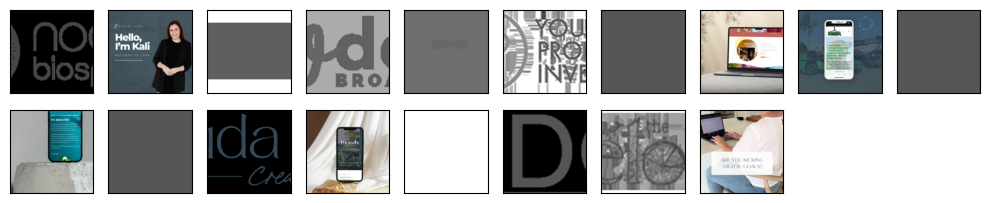

In [93]:
plt.figure(figsize=(10, 100))

# Show all images from the dataset since our dataset is small
# try:
for idx, (image, label_idx) in enumerate(dataset):
    # cur_class = class_names[label_idx]

    try:
        plt.subplot(100, 10, idx+1)
        plt.imshow(denormalize_image(image).permute(1, 2, 0))
        # plt.title(f"{cur_class}")
        plt.xticks([])
        plt.yticks([])
    except Exception as e:
        pass
# except Exception as e:
#     pass

plt.tight_layout()

In [94]:
# read out all images and true labels
image_input, y_true = next(iter(data_batches))
image_input = image_input.to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()


In [101]:
def show_results(image_features, text_features, class_names):
    # depends on global var dataset
    print(f"Image features shape: {image_features.shape}")
    print(f"Text features shape: {text_features.shape}")
    print(f"Class names: {class_names}")

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    k = np.min([len(class_names), 5])
    top_probs, top_labels = text_probs.cpu().topk(k, dim=-1)
    text_probs = text_probs.cpu()

    plt.figure(figsize=(26, 16))

    for i, (image, label_idx) in enumerate(dataset):
        plt.subplot(4, 8, 2 * i + 1)
        plt.imshow(denormalize_image(image).permute(1, 2, 0))
        plt.axis("off")

        plt.subplot(4, 8, 2 * i + 2)
        y = np.arange(k)
        plt.grid()
        plt.barh(y, top_probs[i])
        plt.gca().invert_yaxis()
        plt.gca().set_axisbelow(True)
        plt.yticks(y, [class_names[index] for index in top_labels[i].numpy()])
        # plt.yticks(y, class_names)
        plt.xlabel("probability")

    plt.subplots_adjust(wspace=0.5)
    plt.show()

Image features shape: torch.Size([18, 512])
Text features shape: torch.Size([255, 512])
Class names: ['- we’re strategists, business developers, and', '2023    We wholeheartedly endorse collaborating', '9 February 2023    Highly recommend Luda Creative.', '@coastalcranehire, located on the Sunsh     Hello!', 'All Right Reserved.', 'Although I had to stop the business due to Covid', 'At Luda Creative, we cultivate a customer', 'At Luda, we can handle all of your website', 'At Luda, we love helping businesses elevate.Why', 'Brooke Millar  28 November 2023    Where do I', 'CEO of Luda Creative.Whether it’s kicking', 'Check out the site she did for us.', 'ChrisOwners - CPB&G Read more        Kylie Neale ', 'Clare Beeston  14 November 2022    Kali made a', 'Cosmetic Tattoo     Pyneys Pie Reviews     Aboda', 'Creative - Kali who did a fantastic job in', 'Creative is your go-to studio for', 'Creative your one-stop, approachable website', 'Creative.', 'Dee Rowlands  30 November 2023    Kali ha

ValueError: num must be an integer with 1 <= num <= 32, not 33

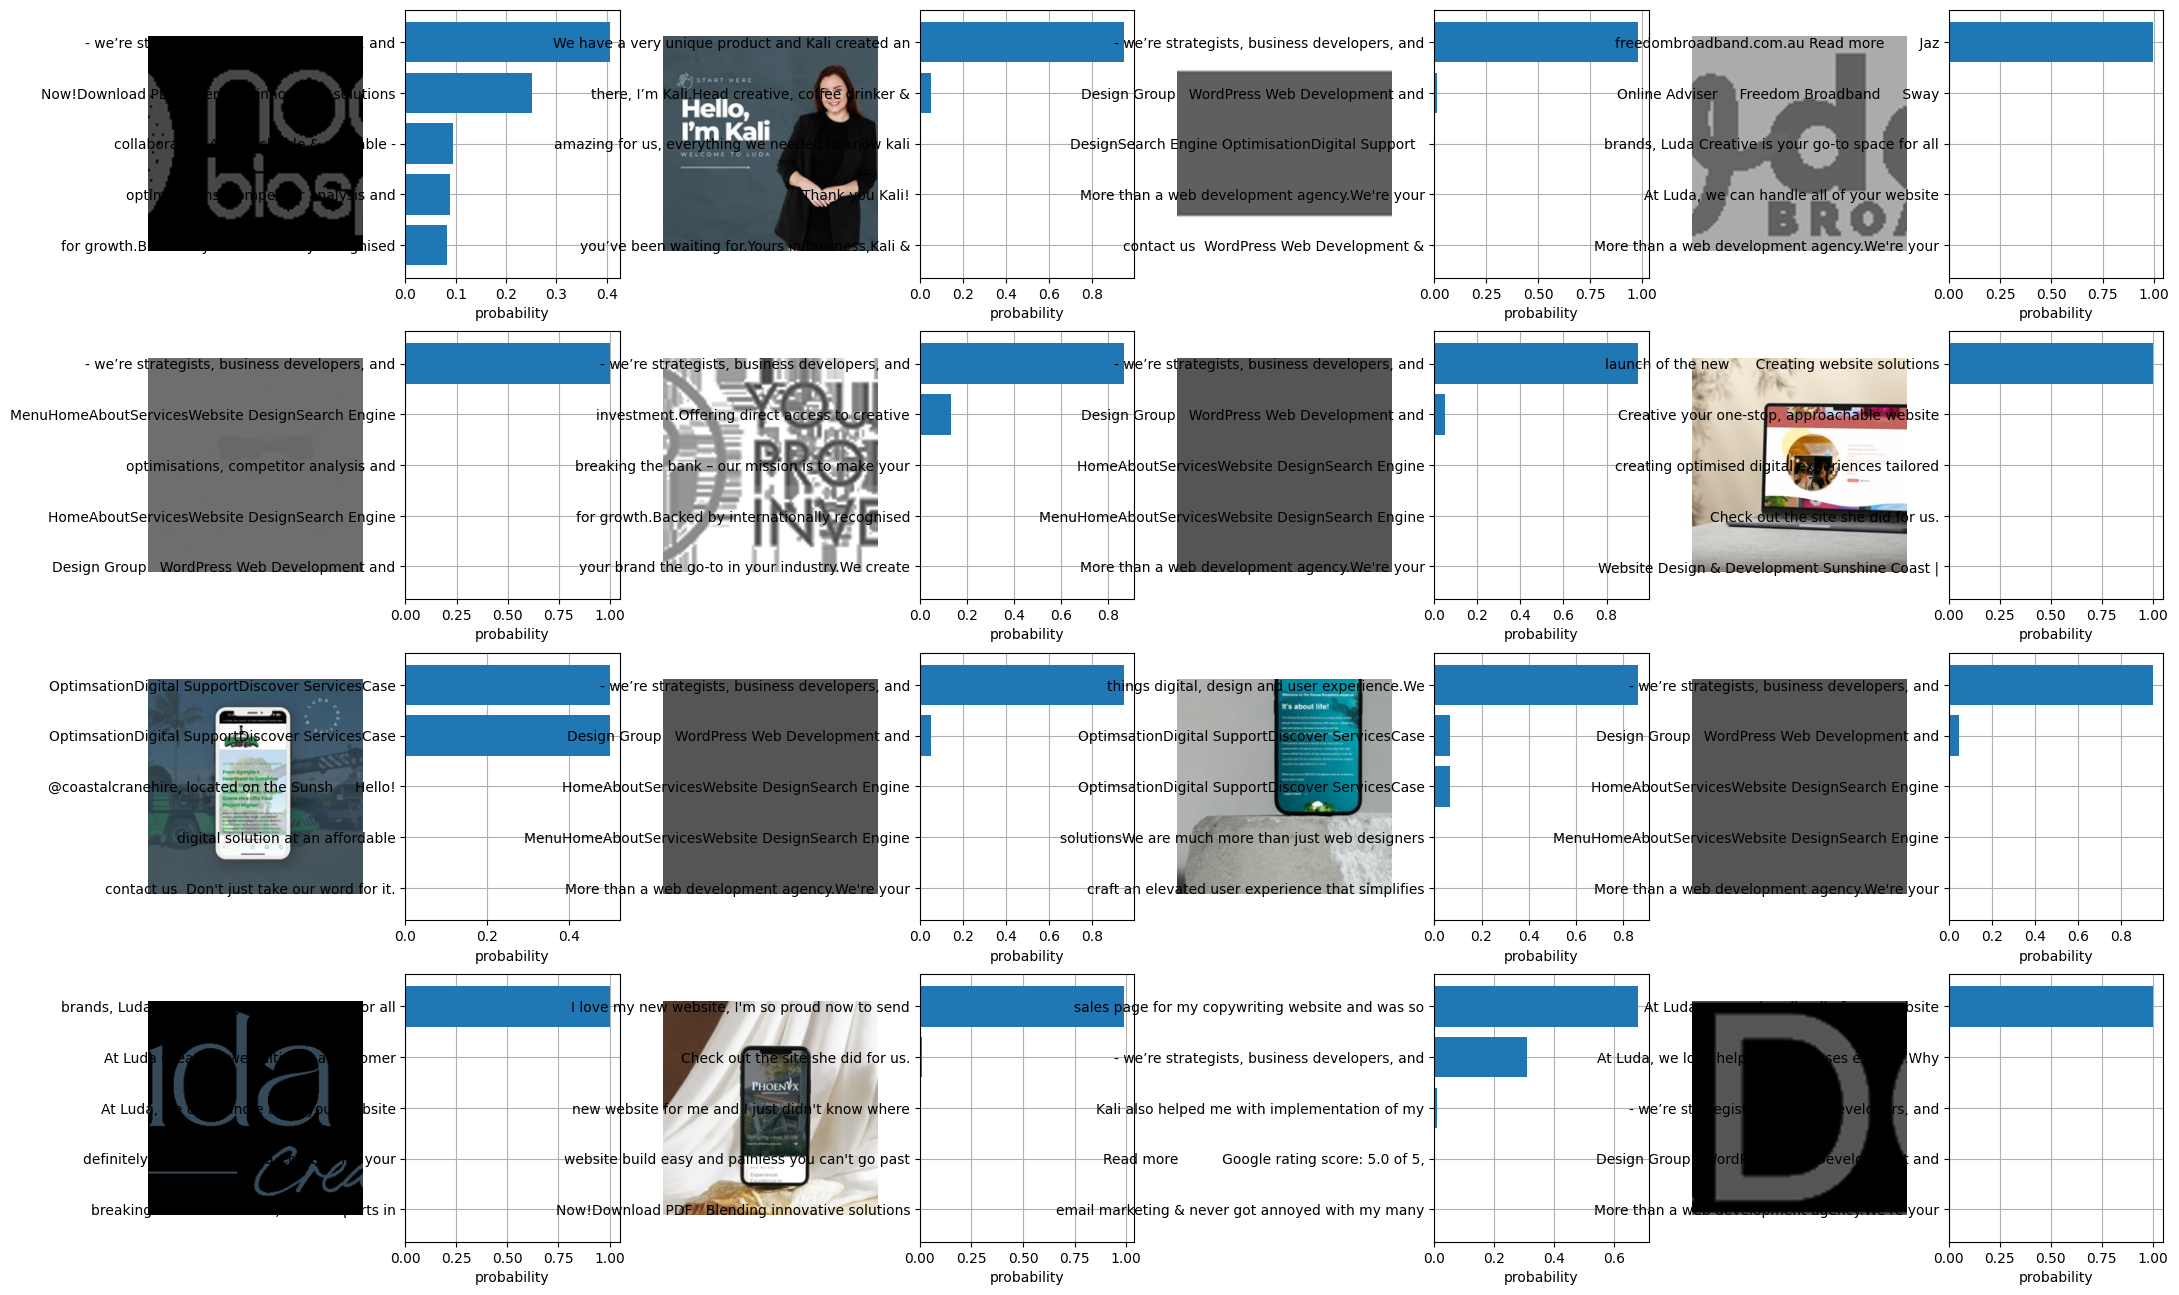

In [102]:
show_results(image_features, text_features, class_names)